In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
from utils import check_paths
import pandas as pd
from scipy.io import loadmat
from scipy.stats import zscore
import joblib
import matplotlib.gridspec as gridspec
import matplotlib

from pactools import Comodulogram, REFERENCES, raw_to_mask

from mne.channels.layout import find_layout
from functools import partial
from mne.defaults import _handle_default

from mne.viz.topo import _erfimage_imshow_unified, _plot_topo

from mne.viz.utils import (
    _setup_vmin_vmax,
    add_background_image
)
from collections import namedtuple

from sparse import save_npz

import scipy.stats
from mne.stats import permutation_cluster_1samp_test, spatio_temporal_cluster_1samp_test, permutation_cluster_test

%matplotlib qt

**Interpretaion of z-scored PAC stats:**
Negative z-scores don’t mean “negative PAC,” just “PAC lower than the group mean.”

**Significant cluster interpretaition:**
Talking about “significant clusters” can be convenient, but you must be aware of all associated caveats! For example, it is invalid to interpret the cluster p value as being spatially or temporally specific. A cluster with sufficiently low (for example < 0.05) p value at specific location does not allow you to say that the significant effect is at that particular location. The p value only tells you about the probability of obtaining similar or stronger/larger cluster anywhere in the data if there were no differences between the compared conditions. So it only allows you to draw conclusions about the differences in the data “in general”, not at specific locations.

**How NOT to interpret results from a cluster-based permutation test:**
https://www.fieldtriptoolbox.org/faq/stats/clusterstats_interpretation/

In [430]:
def _erfimage_imshow(
    ax,
    ch_idx,
    tmin,
    tmax,
    vmin,
    vmax,
    low_fq_range,
    high_fq_range,
    ylim=None,
    data=None,
    epochs=None,
    sigma=None,
    order=None,
    scalings=None,
    vline=None,
    x_label=None,
    y_label=None,
    colorbar=False,
    cmap="RdBu_r",
    vlim_array=None,
):
    """Plot erfimage on sensor topography."""
    import matplotlib.pyplot as plt

    this_data = data[:, ch_idx, :]
    if vlim_array is not None:
        vmin, vmax = vlim_array[ch_idx]

    if callable(order):
        order = order(epochs.times, this_data)

    if order is not None:
        this_data = this_data[order]

    # if sigma > 0.0:
    #     this_data = ndimage.gaussian_filter1d(this_data, sigma=sigma, axis=0)
    img = ax.imshow(
        this_data,
        # extent=[tmin, tmax, 0, len(data)],
        aspect="auto",
        origin="lower",
        vmin=0,
        vmax=0.95*this_data.max(),
        picker=True,
        cmap=cmap,
        interpolation="nearest",
    )
    m, n = this_data.shape

    n_xticks = 5
    xtick_step = n / n_xticks

    xtick_positions = np.arange(-.5, m + 1, xtick_step)
    xtick_labels = np.linspace(low_fq_range[0], low_fq_range[-1], len(xtick_positions))
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels([f'{num :.1f}' for num in xtick_labels])

    n_yticks = 5
    ytick_step = m / n_yticks

    ytick_positions = np.arange(-.5, n + 1, ytick_step)
    ytick_labels = np.linspace(high_fq_range[0], high_fq_range[-1], len(ytick_positions))
    ax.set_yticks(ytick_positions)
    ax.set_yticklabels([f'{num :.1f}' for num in ytick_labels])

    ax = plt.gca()
    if x_label is not None:
        ax.set_xlabel(x_label)
    if y_label is not None:
        ax.set_ylabel(y_label)
    if colorbar:
        plt.colorbar(mappable=img)


def plot_comodulogram(
        data: np.ndarray,
        low_fq_range: np.ndarray,
        high_fq_range: np.ndarray,
        info: mne.Info,
        ch_type: str = 'eeg',
        scalings: dict[str, float] = None,
        title: str = None,
        colorbar: bool = True,
        vmin: float = None,
        vmax: float = None,
        cmap: str = 'viridis',
        ax: plt.Axes = None,
        layout_scale: float = 1,
        fig_facecolor: str = 'w',
        font_color: str = 'k',
        fig_background: plt.Figure = None
) -> plt.Figure:
    
    data = np.transpose(data, (2, 1, 0))
    layout = find_layout(info)
    scalings = _handle_default("scalings", scalings)
    scale_coeffs = [scalings.get(ch_type, 1)]

    vmin, vmax = _setup_vmin_vmax(data, vmin, vmax)
    epochs_plug = namedtuple('EpochsPlug', ['events'])([None])

    show_func = partial(
        _erfimage_imshow_unified,
        scalings=scale_coeffs,
        data=data,
        epochs=epochs_plug,
        sigma=0,
        cmap=cmap
    )
    click_funk = partial(
        _erfimage_imshow,
        low_fq_range=low_fq_range,
        high_fq_range=high_fq_range,
        vmin=None, vmax=None,
        scalings=scale_coeffs,
        data=data,
        epochs=epochs_plug,
        sigma=0,
        cmap=cmap,
        vlim_array=None,
        colorbar=True,
    )

    fig = _plot_topo(
        info=info,
        times=[0, 1],
        show_func=show_func,
        click_func=click_funk,
        layout=layout,
        colorbar=colorbar,
        vmin=0,
        vmax=vmax,
        cmap=cmap,
        layout_scale=layout_scale,
        title=title,
        fig_facecolor=fig_facecolor,
        font_color=font_color,
        unified=True,
        img=True,
        axes=ax
    )
    add_background_image(fig, fig_background)

    return fig


def cosine_similarity_matrix(A: np.ndarray, B: np.ndarray) -> float:
    # Flatten matrices to 1D vectors
    A_flat = A.flatten()
    B_flat = B.flatten()
    
    # Compute cosine similarity
    numerator = np.dot(A_flat, B_flat)
    denominator = np.linalg.norm(A_flat) * np.linalg.norm(B_flat)
    
    return numerator / denominator if denominator != 0 else 0

In [121]:
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
group = 'Y'
subs = os.listdir(os.path.join(eeg_data_dir, group))

task = '_MAIN' # ['_BL', '_MAIN']
task_stage = '_go' # '_plan' or '_go'
block_name = '_adaptation' # ['_baseline', '_adaptation']

group_save_path = os.path.join(eeg_data_dir, f'{group} group')
pac_stats_save_path = os.path.join(group_save_path, 'pac_stats')
check_paths(pac_stats_save_path)


In [ ]:
# choi = ['Fp1', 'Fp2',
#         'F1', 'F2', 'F3', 'F4', 'F5', 'F6',
#         'AF3', 'AF4', 'AF7', 'AF8',
#         'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6',
#         'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
#         'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6']

In [ ]:
pac_list = []
pac_zscore_list = []

for sub_name in subs: # [subs[0]]
    sub_dir = os.path.join(eeg_data_dir, group, sub_name)
    pac_dir = os.path.join(sub_dir, 'pac_results')

    if sub_name == subs[0]: # read one epochs file to extract info
        # Load EEG data
        epochs_path = os.path.join(eeg_data_dir, group, sub_name, 'preproc', 'analysis') 
        epochs = mne.read_epochs(os.path.join(epochs_path, f"{sub_name}{task}_epochs{task_stage}{block_name}-epo.fif"), preload=True)
        eeg_channel_names = epochs.copy().pick("eeg").ch_names
        epochs.pick(eeg_channel_names)
        # info = epochs.info
        # epochs.pick(choi)

    # Load PAC data
    pac = np.load(os.path.join(pac_dir, f"pac_mi_TOPO_{sub_name[-5:]}{task}{task_stage}{block_name}.npy"))
    pac_t = np.transpose(pac, (1, 0, 2))
    pac_list.append(pac_t)
    pac_zscore_list.append(zscore(pac_t))
    
# Stack them along a new first axis (subject axis)
pac_all = np.stack(pac_list, axis=0)
pac_zscore_all = np.stack(pac_zscore_list, axis=0)
print(pac_all.shape) # (24, 60, 20, 20) subs x electrodes x ph_freqs x amp_freqs
print(pac_zscore_all.shape)

# Average over subjects
pac_zscore_mean = pac_zscore_all.mean(axis=0)  # shape: (60, 20, 20)

# Save the PAC data
np.save(os.path.join(pac_stats_save_path, f"pac_mi_{group}{task}{task_stage}{block_name}_RAW.npy"), pac_all)
np.save(os.path.join(pac_stats_save_path, f"pac_mi_{group}{task}{task_stage}{block_name}_ZSCORE.npy"), pac_zscore_all)
np.save(os.path.join(pac_stats_save_path, f"pac_mi_{group}{task}{task_stage}{block_name}_ZSCORE_MEAN.npy"), pac_zscore_mean)


In [ ]:
# find_ch_adjacency first attempts to find an existing "neighbor"
# (adjacency) file for given sensor layout.
# If such a file doesn't exist, an adjacency matrix is computed on the fly,
# using Delaunay triangulations.
sensor_adjacency, ch_names = mne.channels.find_ch_adjacency(epochs.info, "eeg")
# print(sensor_adjacency)
# print(ch_names)

adjacency = mne.stats.combine_adjacency(
    sensor_adjacency, pac_all.shape[2], pac_all.shape[3]
)

save_npz(f"{group}{task}{task_stage}{block_name}_adjacency matrix.npz", adjacency)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 60


In [519]:
adjacency.shape

(24000, 24000)

In [348]:
print(adjacency.min())
print(adjacency.max())
print(adjacency.mean())

0.0
1.0
0.00042083333333333333


In [ ]:
num_ones = (adjacency.data == 1).sum()
print(f"Number of entries equal to 1: {num_ones}")

num_zeros = (adjacency.data == 0).sum()
print(f"Number of entries equal to 0: {num_zeros}")

Number of entries equal to 1: 242400
Number of entries equal to 0: 0


In [ ]:
adjacency_dense = adjacency.toarray()
print((adjacency_dense == 1).sum())  # Count the 1s
print((adjacency_dense == 0).sum())  # Count the 0s
print((adjacency_dense == 1).sum() + (adjacency_dense == 0).sum())  # Total number of entries

242400
575757600
576000000


In [ ]:
# We want a two-tailed test
tail = 0

# In this example, we wish to set the threshold for including data bins in
# the cluster forming process to the t-value corresponding to p=0.01 for the
# given data.

# Because we conduct a two-tailed test, we divide the p-value by 2 (which means
# we're making use of both tails of the distribution).
# As the degrees of freedom, we specify the number of observations
# (here: epochs) minus 1.
# Finally, we subtract 0.01 / 2 from 1, to get the critical t-value
# on the right tail (this is needed for MNE-Python internals)
degrees_of_freedom = pac_all.shape[0] - 1
t_thresh = scipy.stats.t.ppf(1 - 0.01 / 2, df=degrees_of_freedom)

# Set the number of permutations to run.
n_permutations = 10000

# Run the analysis
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    pac_zscore_all,
    n_permutations=n_permutations,
    threshold=t_thresh,
    tail=tail,
    adjacency=adjacency,
    out_type="mask",
    max_step=1,
    verbose=True,
)

stat_fun(H1): min=-7.928092559835753 max=3.8402412437262656
Running initial clustering …
Found 68 clusters


100%|██████████| Permuting : 9999/9999 [15:00<00:00,   11.10it/s]


In [ ]:
# SANITY CHECKS
print(f't_thresh = {t_thresh}')
print(f'T_obs_mean = {T_obs.mean()}')
print(f'cluster_p_values = {cluster_p_values}')

alpha = 0.05  # significance threshold
significant_clusters = [i for i, p in enumerate(cluster_p_values) if p < alpha]
print(f"Found {len(significant_clusters)} significant clusters")

np.float64(2.4998667394943976)

In [137]:
# PLOTTING

fig_group_path = os.path.join(pac_stats_save_path, 'figs')
fig_group_save_path = os.path.join(fig_group_path, group)
fig_task_save_path = os.path.join(fig_group_path, group, task)
check_paths(fig_group_path, fig_group_save_path, fig_task_save_path)


# Reshape the stats results
T_obs_reshaped = T_obs.reshape(pac_zscore_all.shape[1:])  # (30, 20, 20)
sig_mask_reshaped = np.zeros_like(T_obs_reshaped, dtype=bool)

for i in significant_clusters:
    sig_mask_reshaped[clusters[i].reshape(pac_zscore_all.shape[1:])] = True


for elec_idx in range(pac_zscore_mean.shape[0]):
    # Create masked array: T-values where significant, NaN elsewhere
    masked_T = np.where(sig_mask_reshaped[elec_idx], T_obs_reshaped[elec_idx], np.nan)

    # # Build a colormap with gray for NaNs
    cmap = plt.cm.RdYlBu.copy()  # try 'PiYG' (pink-green) or 'PRGn' (purple-green)
    cmap.set_bad(color='lightgray')  # this sets the NaNs to gray

    # Plot
    plt.figure(figsize=(6, 5))
    im = plt.imshow(
        masked_T,
        origin='lower',
        aspect='equal',
        cmap=cmap,
        interpolation='none',
        vmin=-10,
        vmax=10
    )
    plt.colorbar(im, label='T-value')
    plt.title(f'{group}{task}{task_stage}{block_name}: PAC Cluster stats - {eeg_channel_names[elec_idx]}')
    plt.xlabel('Amplitude Freq Index')
    plt.ylabel('Phase Freq Index')
    plt.tight_layout()
    plt.show()

    plt.savefig(os.path.join(fig_task_save_path, f"pac_cluster_stats_{group}{task}{task_stage}{block_name}_{eeg_channel_names[elec_idx]}.png"), dpi=300)



In [133]:
print(fig_task_save_path)

D:\BonoKat\research project\# study 1\eeg_data\set\Y group\pac_stats\figs\Y\_MAIN


In [60]:
masked_T

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [ ]:
masked_T.any() != np.nan

np.True_

_____

In [ ]:
adjacency = mne.stats.combine_adjacency(sensor_adjacency, pac_all.shape[2], pac_all.shape[3])
t_thresh = scipy.stats.t.ppf(1 - 0.01, df=degrees_of_freedom)
print(t_thresh)

# transpose pac_all to (observations × time × frequencies × space)
pac_reshaped = pac_all.transpose(0, 2, 3, 1)  # (24, 20, 20, 30)

# Run the analysis
T_obsr, clustersr, cluster_p_valuesr, H0r = permutation_cluster_1samp_test(
    pac_reshaped,
    n_permutations=n_permutations,
    threshold=t_thresh,
    tail=tail,
    adjacency=adjacency,
    out_type="mask",
    max_step=1,
    verbose=True,
)

alpha = 0.05  # significance threshold
significant_clusters = [i for i, p in enumerate(cluster_p_valuesr) if p < alpha]
print(f"Found {len(significant_clusters)} significant clusters")

2.4998667394943976
stat_fun(H1): min=2.759479432347395 max=17.896450596877248
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 9999/9999 [01:57<00:00,   85.39it/s]

Found 1 significant clusters


Text(0, 0.5, 'T-value')

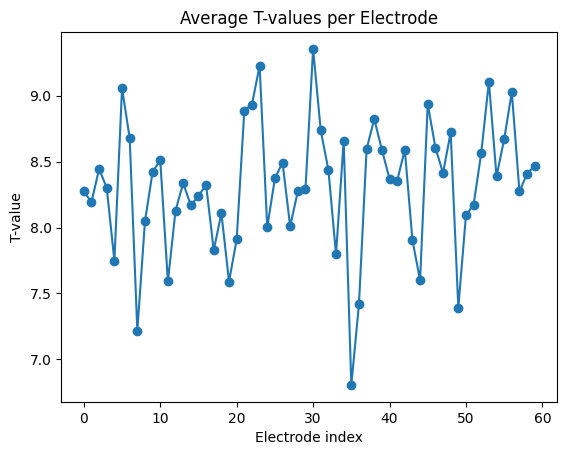

In [452]:
T_avg = T_obs.mean(axis=(2, 1))  # shape: (60,)

plt.figure()
plt.plot(T_avg, marker='o', linestyle='-')
plt.title("Average T-values per Electrode")
plt.xlabel("Electrode index")
plt.ylabel("T-value")

Text(0, 0.5, 'T-value')

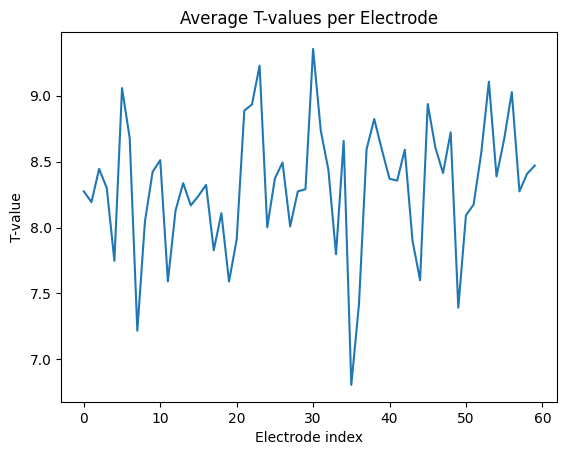

In [466]:
T_avgr = T_obsr.mean(axis=(1, 0))  # shape: (30,)

plt.figure()
plt.plot(T_avgr)
plt.title("Average T-values per Electrode")
plt.xlabel("Electrode index")
plt.ylabel("T-value")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib qt

# Average over subjects
pac_mean = pac_all.mean(axis=0)  # shape: (60, 20, 20)

# for chan in range(2):# range(pac_mean.shape[0]):

    # plt.figure(figsize=(6, 5))
    # plt.imshow(
    #     pac_mean[chan].T,  # shape: (phase, amp)
    #     origin='lower',
    #     aspect='equal',
    #     cmap='magma'
    # )
    # plt.colorbar(label='PAC')
    # plt.title(f'Mean PAC - Electrode {chan}')
    # plt.xlabel('Phase Freq Index')
    # plt.ylabel('Amplitude Freq Index')
    # plt.tight_layout()
    # plt.show()


# Create an empty mask
sig_mask = np.zeros_like(T_obs, dtype=bool)

# Mark significant clusters
for i in significant_clusters:
    sig_mask[clusters[i]] = True

# Average T_obs over subjects, reshape it
T_obs_reshaped = T_obs.reshape(pac_all.shape[1:])  # (60, 20, 20)
sig_mask_reshaped = sig_mask.reshape(pac_all.shape[1:])  # same shape

for chan in range(pac_mean.shape[0]):

    plt.figure(figsize=(6, 5))
    plt.imshow(
        T_obs_reshaped[chan].T, 
        origin='lower',
        aspect='equal',
        cmap='Blues',
    )
    plt.colorbar(label='T-value')
    plt.title(f'T-map with Clusters - Electrode {chan}')
    plt.xlabel('Phase Freq Index')
    plt.ylabel('Amplitude Freq Index')

    # Overlay significant cluster
    plt.contour(sig_mask_reshaped[chan], levels=[0.5], colors='red', linewidths=1.5)

    plt.tight_layout()
    plt.show()

In [509]:
plt.contour(sig_mask_reshaped[chan], levels=[0.5], colors='red', linewidths=1.5)

In [77]:
find_layout(epochs.info, ch_type='eeg')

<Layout | EEG - Channels: Fp1, Fp2, F1 ...>

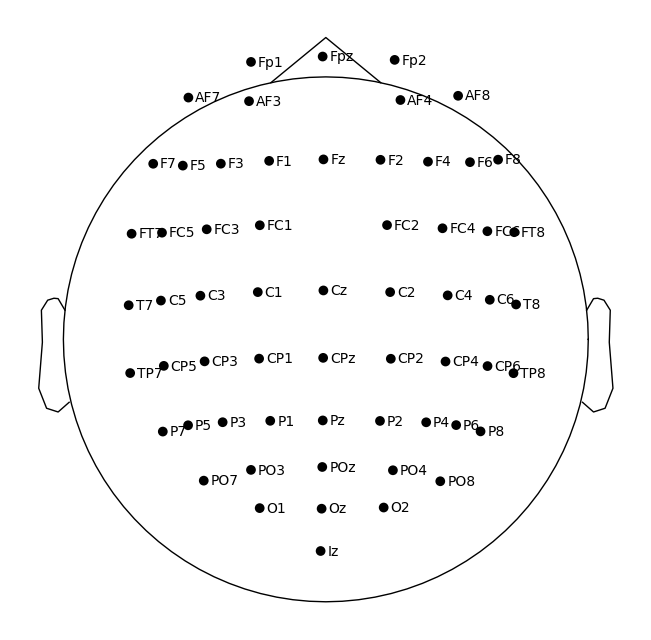

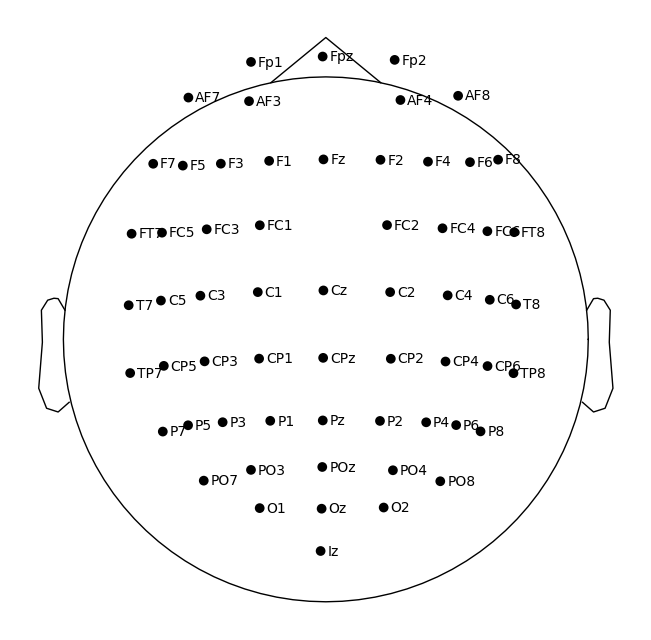

In [60]:
epochs.plot_sensors(ch_type='eeg', kind='topomap', show_names=True, title='EEG channels')

In [ ]:
print(epochs.info['ch_names'])

In [271]:
pairs = []
for i, j in zip(eeg_channel_names, sensor_adjacency.toarray()[-1]):
    pairs.append([i, j])
    if j == 1:
        print([i, j])
# print(pairs)

['O1', np.int64(1)]
['O2', np.int64(1)]
['Iz', np.int64(1)]
['POz', np.int64(1)]
['Oz', np.int64(1)]


C:\Users\a1902989\AppData\Local\Temp\ipykernel_14360\3448751919.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


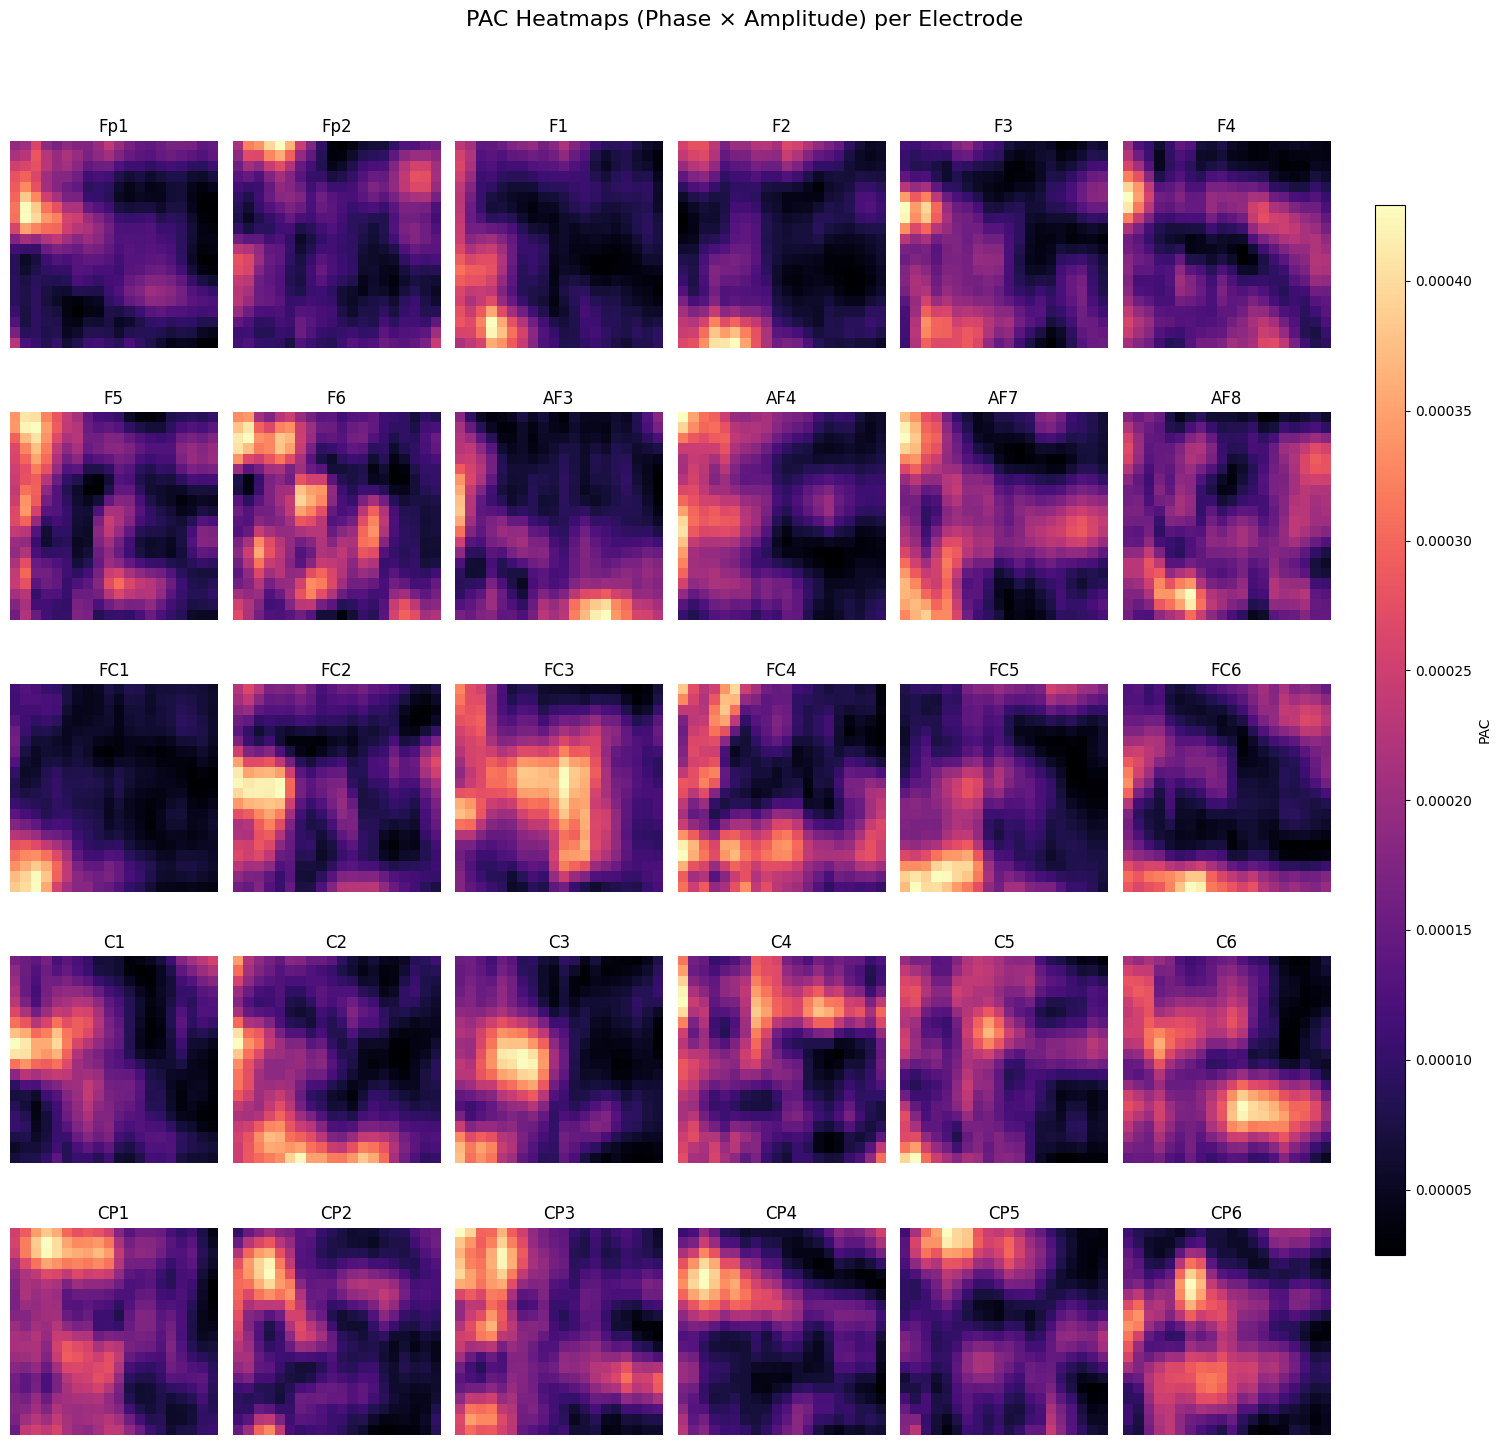

In [ ]:
# Visualize PAC results for one subject

n_phase, n_electrodes, n_amp = pac.shape

fig, axes = plt.subplots(5, 6, figsize=(15, 15))  # 30 electrodes in 5x6 grid
axes = axes.flatten()

for i in range(n_electrodes):
    ch_name = choi[i]
    ax = axes[i]
    im = ax.imshow(pac[:, i, :].T, cmap='magma', aspect='equal', origin='lower')
    ax.set_title(ch_name)
    ax.axis('off')

# Add a colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='PAC')

plt.suptitle("PAC Heatmaps (Phase × Amplitude) per Electrode", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

In [ ]:
def permutation_cluster_1samp_test(
    X,
    threshold=None,
    n_permutations=1024,
    tail=0,
    stat_fun=None,
    adjacency=None,
    n_jobs=None,
    seed=None,
    max_step=1,
    exclude=None,
    step_down_p=0,
    t_power=1,
    out_type="indices",
    check_disjoint=False,
    buffer_size=1000,
    verbose=None,
):
    """Non-parametric cluster-level paired t-test.

    For details, see :footcite:p:`MarisOostenveld2007,Sassenhagen2019`.

    Parameters
    ----------
    X : array, shape (n_observations, p[, q][, r])
        The data to be clustered. The first dimension should correspond to the
        difference between paired samples (observations) in two conditions.
        The subarrays ``X[k]`` can be 1D (e.g., time series), 2D (e.g.,
        time series over channels), or 3D (e.g., time-frequencies over
        channels) associated with the kth observation. For spatiotemporal data,
        see also :func:`mne.stats.spatio_temporal_cluster_1samp_test`.
    %(threshold_clust_t)s
    %(n_permutations_clust_all)s
    %(tail_clust)s
    %(stat_fun_clust_t)s
    %(adjacency_clust_1)s
    %(n_jobs)s
    %(seed)s
    %(max_step_clust)s
    %(exclude_clust)s
    %(step_down_p_clust)s
    %(t_power_clust)s
    %(out_type_clust)s
    %(check_disjoint_clust)s
    %(buffer_size_clust)s
    %(verbose)s

    Returns
    -------
    t_obs : array, shape (p[, q][, r])
        T-statistic observed for all variables.
    clusters : list
        List type defined by out_type above.
    cluster_pv : array
        P-value for each cluster.
    H0 : array, shape (n_permutations,)
        Max cluster level stats observed under permutation.

    Notes
    -----
    From an array of paired observations, e.g. a difference in signal
    amplitudes or power spectra in two conditions, calculate if the data
    distributions in the two conditions are significantly different.
    The procedure uses a cluster analysis with permutation test
    for calculating corrected p-values. Randomized data are generated with
    random sign flips. See :footcite:`MarisOostenveld2007` for more
    information.

    Because a 1-sample t-test on the difference in observations is
    mathematically equivalent to a paired t-test, internally this function
    computes a 1-sample t-test (by default) and uses sign flipping (always)
    to perform permutations. This might not be suitable for the case where
    there is truly a single observation under test; see :ref:`disc-stats`.
    %(threshold_clust_t_notes)s

    If ``n_permutations`` exceeds the maximum number of possible permutations
    given the number of observations, then ``n_permutations`` and ``seed``
    will be ignored since an exact test (full permutation test) will be
    performed (this is the case when
    ``n_permutations >= 2 ** (n_observations - (tail == 0))``).

    If no initial clusters are found because all points in the true
    distribution are below the threshold, then ``clusters``, ``cluster_pv``,
    and ``H0`` will all be empty arrays.

    References
    ----------
    .. footbibliography::
    """
    stat_fun, threshold = _check_fun(X, stat_fun, threshold, tail)
    return _permutation_cluster_test(
        X=[X],
        threshold=threshold,
        n_permutations=n_permutations,
        tail=tail,
        stat_fun=stat_fun,
        adjacency=adjacency,
        n_jobs=n_jobs,
        seed=seed,
        max_step=max_step,
        exclude=exclude,
        step_down_p=step_down_p,
        t_power=t_power,
        out_type=out_type,
        check_disjoint=check_disjoint,
        buffer_size=buffer_size,
    )

In [ ]:
def _check_fun(X, stat_fun, threshold, tail=0, kind="within"):
    """Check the stat_fun and threshold values."""
    if kind == "within":
        if threshold is None:
            if stat_fun is not None and stat_fun is not ttest_1samp_no_p:
                warn(
                    "Automatic threshold is only valid for stat_fun=None "
                    f"(or ttest_1samp_no_p), got {stat_fun}"
                )
            p_thresh = 0.05 / (1 + (tail == 0))
            n_samples = len(X)
            threshold = -tstat.ppf(p_thresh, n_samples - 1)
            if np.sign(tail) < 0:
                threshold = -threshold
            logger.info(f"Using a threshold of {threshold:.6f}")
        stat_fun = ttest_1samp_no_p if stat_fun is None else stat_fun
    else:
        assert kind == "between"
        if threshold is None:
            if stat_fun is not None and stat_fun is not f_oneway:
                warn(
                    "Automatic threshold is only valid for stat_fun=None "
                    f"(or f_oneway), got {stat_fun}"
                )
            elif tail != 1:
                warn('Ignoring argument "tail", performing 1-tailed F-test')
            p_thresh = 0.05
            dfn = len(X) - 1
            dfd = np.sum([len(x) for x in X]) - len(X)
            threshold = fstat.ppf(1.0 - p_thresh, dfn, dfd)
            logger.info(f"Using a threshold of {threshold:.6f}")
        stat_fun = f_oneway if stat_fun is None else stat_fun
    return stat_fun, threshold

In [ ]:
def _permutation_cluster_test(
    X,
    threshold,
    n_permutations,
    tail,
    stat_fun,
    adjacency,
    n_jobs,
    seed,
    max_step,
    exclude,
    step_down_p,
    t_power,
    out_type,
    check_disjoint,
    buffer_size,
):
    """Aux Function.

    Note. X is required to be a list. Depending on the length of X
    either a 1 sample t-test or an F test / more sample permutation scheme
    is elicited.
    """
    _check_option("out_type", out_type, ["mask", "indices"])
    _check_option("tail", tail, [-1, 0, 1])
    if not isinstance(threshold, dict):
        threshold = float(threshold)
        if (
            tail < 0
            and threshold > 0
            or tail > 0
            and threshold < 0
            or tail == 0
            and threshold < 0
        ):
            raise ValueError(
                f"incompatible tail and threshold signs, got {tail} and {threshold}"
            )

    # check dimensions for each group in X (a list at this stage).
    X = [x[:, np.newaxis] if x.ndim == 1 else x for x in X]
    n_samples = X[0].shape[0]
    n_times = X[0].shape[1]

    sample_shape = X[0].shape[1:]
    for x in X:
        if x.shape[1:] != sample_shape:
            raise ValueError("All samples mush have the same size")

    # flatten the last dimensions in case the data is high dimensional
    X = [np.reshape(x, (x.shape[0], -1)) for x in X]
    n_tests = X[0].shape[1]

    if adjacency is not None and adjacency is not False:
        adjacency = _setup_adjacency(adjacency, n_tests, n_times)

    if (exclude is not None) and not exclude.size == n_tests:
        raise ValueError("exclude must be the same shape as X[0]")

    # Step 1: Calculate t-stat for original data
    # -------------------------------------------------------------
    t_obs = stat_fun(*X)
    _validate_type(t_obs, np.ndarray, "return value of stat_fun")
    logger.info(f"stat_fun(H1): min={np.min(t_obs)} max={np.max(t_obs)}")

    # test if stat_fun treats variables independently
    if buffer_size is not None:
        t_obs_buffer = np.zeros_like(t_obs)
        for pos in range(0, n_tests, buffer_size):
            t_obs_buffer[pos : pos + buffer_size] = stat_fun(
                *[x[:, pos : pos + buffer_size] for x in X]
            )

        if not np.all(t_obs == t_obs_buffer):
            warn(
                "Provided stat_fun does not treat variables independently. "
                "Setting buffer_size to None."
            )
            buffer_size = None

    # The stat should have the same shape as the samples for no adj.
    if t_obs.size != np.prod(sample_shape):
        raise ValueError(
            f"t_obs.shape {t_obs.shape} provided by stat_fun {stat_fun} is not "
            f"compatible with the sample shape {sample_shape}"
        )
    if adjacency is None or adjacency is False:
        t_obs.shape = sample_shape

    if exclude is not None:
        include = np.logical_not(exclude)
    else:
        include = None

    # determine if adjacency itself can be separated into disjoint sets
    if check_disjoint is True and (adjacency is not None and adjacency is not False):
        partitions = _get_partitions_from_adjacency(adjacency, n_times)
    else:
        partitions = None
    logger.info("Running initial clustering …")
    out = _find_clusters(
        t_obs,
        threshold,
        tail,
        adjacency,
        max_step=max_step,
        include=include,
        partitions=partitions,
        t_power=t_power,
        show_info=True,
    )
    clusters, cluster_stats = out

    # The stat should have the same shape as the samples
    t_obs.shape = sample_shape

    # For TFCE, return the "adjusted" statistic instead of raw scores
    # and for clusters, each point gets treated independently
    tfce = isinstance(threshold, dict)
    if tfce:
        t_obs = cluster_stats.reshape(t_obs.shape) * np.sign(t_obs)
        clusters = [np.array([c]) for c in range(t_obs.size)]

    logger.info(f"Found {len(clusters)} cluster{_pl(clusters)}")

    # convert clusters to old format
    if (adjacency is not None and adjacency is not False) or tfce:
        # our algorithms output lists of indices by default
        if out_type == "mask":
            slice_out = (adjacency is None) & (len(sample_shape) == 1)
            clusters = _cluster_indices_to_mask(clusters, n_tests, slice_out)
    else:
        # ndimage outputs slices or boolean masks by default,
        if out_type == "indices":
            clusters = _cluster_mask_to_indices(clusters, t_obs.shape)

    # convert our seed to orders
    # check to see if we can do an exact test
    # (for a two-tailed test, we can exploit symmetry to just do half)
    extra = ""
    rng = check_random_state(seed)
    del seed
    if len(X) == 1:  # 1-sample test
        do_perm_func = _do_1samp_permutations
        X_full = X[0]
        slices = None
        orders, n_permutations, extra = _get_1samp_orders(
            n_samples, n_permutations, tail, rng
        )
    else:
        n_permutations = int(n_permutations)
        do_perm_func = _do_permutations
        X_full = np.concatenate(X, axis=0)
        n_samples_per_condition = [x.shape[0] for x in X]
        splits_idx = np.append([0], np.cumsum(n_samples_per_condition))
        slices = [slice(splits_idx[k], splits_idx[k + 1]) for k in range(len(X))]
        orders = [rng.permutation(len(X_full)) for _ in range(n_permutations - 1)]
    del rng
    parallel, my_do_perm_func, n_jobs = parallel_func(
        do_perm_func, n_jobs, verbose=False
    )

    if len(clusters) == 0:
        warn("No clusters found, returning empty H0, clusters, and cluster_pv")
        return t_obs, np.array([]), np.array([]), np.array([])

    # Step 2: If we have some clusters, repeat process on permuted data
    # -------------------------------------------------------------------
    # Step 3: repeat permutations for step-down-in-jumps procedure
    n_removed = 1  # number of new clusters added
    total_removed = 0
    step_down_include = None  # start out including all points
    n_step_downs = 0

    while n_removed > 0:
        # actually do the clustering for each partition
        if include is not None:
            if step_down_include is not None:
                this_include = np.logical_and(include, step_down_include)
            else:
                this_include = include
        else:
            this_include = step_down_include

        with ProgressBar(
            iterable=range(len(orders)), mesg=f"Permuting{extra}"
        ) as progress_bar:
            H0 = parallel(
                my_do_perm_func(
                    X_full,
                    slices,
                    threshold,
                    tail,
                    adjacency,
                    stat_fun,
                    max_step,
                    this_include,
                    partitions,
                    t_power,
                    order,
                    sample_shape,
                    buffer_size,
                    progress_bar.subset(idx),
                )
                for idx, order in split_list(orders, n_jobs, idx=True)
            )
        # include original (true) ordering
        if tail == -1:  # up tail
            orig = cluster_stats.min()
        elif tail == 1:
            orig = cluster_stats.max()
        else:
            orig = abs(cluster_stats).max()
        H0.insert(0, [orig])
        H0 = np.concatenate(H0)
        logger.debug("Computing cluster p-values")
        cluster_pv = _pval_from_histogram(cluster_stats, H0, tail)

        # figure out how many new ones will be removed for step-down
        to_remove = np.where(cluster_pv < step_down_p)[0]
        n_removed = to_remove.size - total_removed
        total_removed = to_remove.size
        step_down_include = np.ones(n_tests, dtype=bool)
        for ti in to_remove:
            step_down_include[clusters[ti]] = False
        if adjacency is None and adjacency is not False:
            step_down_include.shape = sample_shape
        n_step_downs += 1
        if step_down_p > 0:
            a_text = "additional " if n_step_downs > 1 else ""
            logger.info(
                "Step-down-in-jumps iteration #%i found %i %s"
                "cluster%s to exclude from subsequent iterations",
                n_step_downs,
                n_removed,
                a_text,
                _pl(n_removed),
            )

    # The clusters should have the same shape as the samples
    clusters = _reshape_clusters(clusters, sample_shape)
    return t_obs, clusters, cluster_pv, H0
